This notebook explores how to extract features from oriented 3D brains and tumor masks.
We are using [this radiomic feature library](https://pyradiomics.readthedocs.io/en/latest/index.html).

In [1]:
import glob
import os
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
import math
from tqdm.auto import tqdm
import SimpleITK as sitk
import radiomics

In [2]:
df = pd.read_csv('../input/train_labels_folds-v1.csv')
df.head()

,BraTS21ID,MGMT_value,fold
0,0,1,2
1,2,1,2
2,3,0,1
3,5,1,2
4,6,1,0


In [3]:
REG_DIR = '../input/registered_cases/train/'
SEG_DIR = '../output/OOF_segmentations_256/'

In [4]:
df_all = pd.read_csv('../input/train_feature_data_v2.csv')
df_all.head()

,Unnamed: 0,BraTS21ID,MGMT_value,fold,mesh_volume,surface_area,surface_volume_ratio,sphericity,spherical_disproportion,maximum_3d_diameter,...,mean_ax_1,median_ax_1,percentile90_ax_1,maximum_ax_1,minimum_ax_2,percentile10_ax_2,mean_ax_2,median_ax_2,percentile90_ax_2,maximum_ax_2
0,0,0,1,2,159374.833333,20741.269121,0.130141,0.685376,1.459054,237.766692,...,165.275800,165.0,194.0,211,25,31.0,41.037986,41.0,51.0,59
1,1,2,1,2,196020.500000,26098.518115,0.133142,0.625272,1.599303,135.417872,...,177.636621,178.0,205.0,220,32,41.0,55.660076,55.0,70.0,79
2,2,3,0,1,227281.125000,24005.453200,0.105620,0.750268,1.332857,115.047816,...,158.150338,158.0,190.0,213,49,62.0,74.993091,75.0,88.0,95
3,3,5,1,2,278976.750000,31507.001329,0.112938,0.655323,1.525964,171.642069,...,170.655096,169.0,206.0,229,33,55.0,67.263955,67.0,80.0,91
4,4,6,1,0,307876.916667,30149.226650,0.097926,0.731351,1.367332,140.484875,...,141.050640,139.0,181.0,212,34,42.0,55.577350,55.0,71.0,83


## Feature model

In [5]:
import xgboost as xgb
from sklearn import linear_model
import optuna
import seaborn as sns

In [6]:
all_feat_names = df_all.columns.to_list()[4:]
corr = df_all[['MGMT_value'] + all_feat_names].corr()

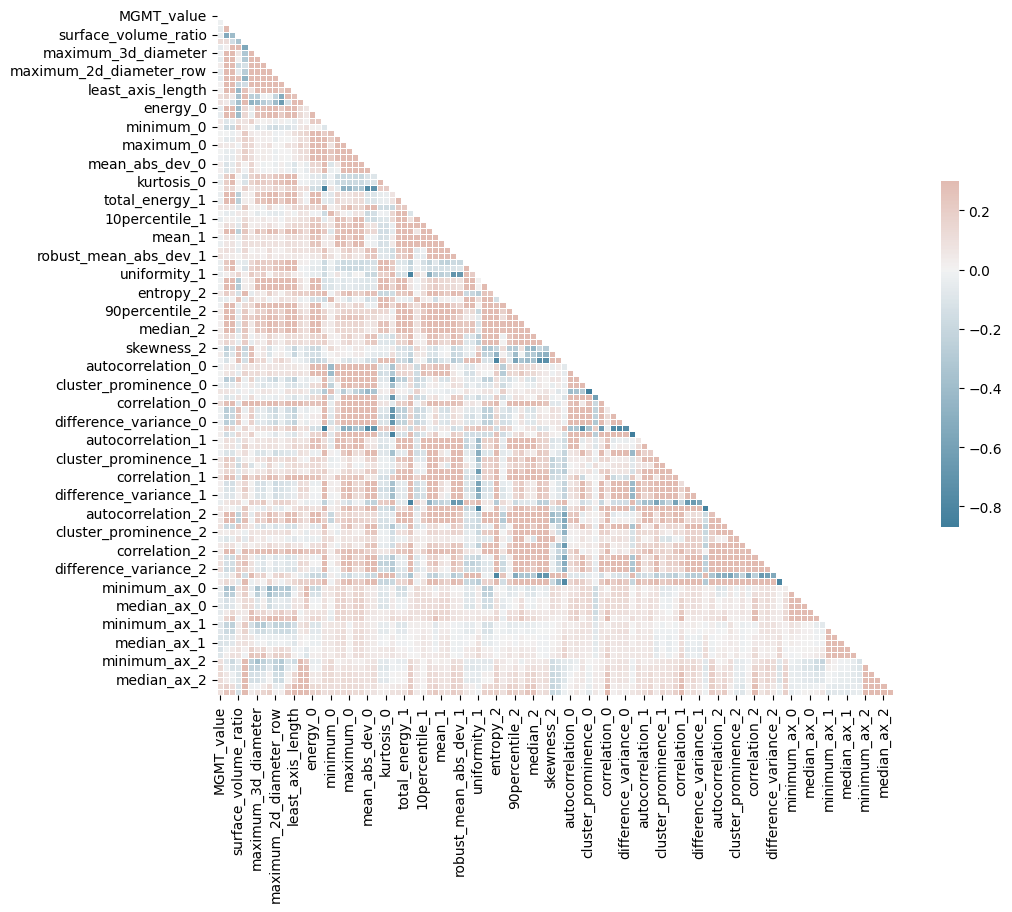

In [7]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.close('all')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [8]:
mgmt_corr_sorted = corr['MGMT_value'].sort_values()
mgmt_corr_sorted[:5], mgmt_corr_sorted[-6:-1]

(percentile90_ax_1   -0.115617
 median_ax_1         -0.107567
 mean_ax_1           -0.103234
 maximum_ax_1        -0.090067
 percentile10_ax_1   -0.082246
 Name: MGMT_value, dtype: float64,
 correlation_0        0.119817
 median_ax_2          0.126024
 percentile10_ax_2    0.126604
 percentile90_ax_2    0.127253
 mean_ax_2            0.128695
 Name: MGMT_value, dtype: float64)

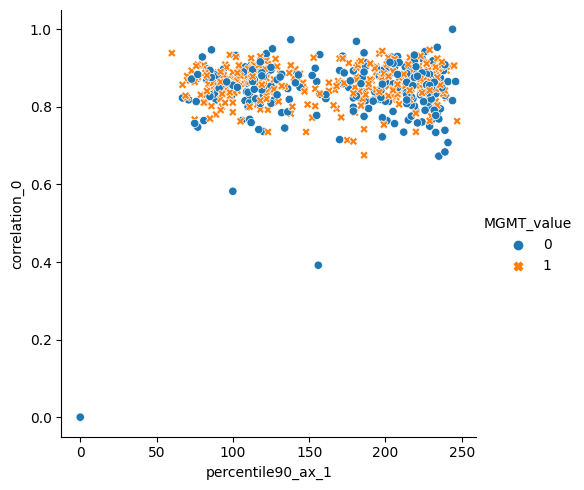

In [9]:
sns.relplot(x='percentile90_ax_1', y="correlation_0", hue="MGMT_value", style="MGMT_value", data=df_all)
plt.show()

In [74]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

def get_data(fold, features, noise_aug_lvl=0, multiply_train:int=1, rnd_seed=123):
    """
    Splits data to train and val sets and adds optionally
    random noise to train set with noise mean = 0, std = noise_aug_lvl * feature_std 
    """
    np.random.seed(rnd_seed)
    df = df_all.dropna(inplace=False)
    scaler = StandardScaler()
    
    df_train = df[df.fold != fold]
    df_val = df[df.fold == fold]
    if len(df_val) == 0:
        df_val = df[df.fold == 0]
    
    # shuffle train
    df_train = df_train.sample(frac=1)
    
    y_train = df_train.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    y_val = df_val.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    
    X_train = df_train[features].to_numpy().astype(np.float32)
    X_val = df_val[features].to_numpy().astype(np.float32)
    
    # augmentation
    if multiply_train > 1:
        X_train = np.concatenate([X_train for _ in range(multiply_train)], 0)
        y_train = np.concatenate([y_train for _ in range(multiply_train)], 0)
    if noise_aug_lvl > 0:
        for col in range(X_train.shape[1]):
            X_train[:,col] += np.random.normal(
                scale = noise_aug_lvl * np.std(X_train[:,col]),
                size= X_train[:,col].shape
            )
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, y_train, X_val, y_val, scaler, (df_train.index.values).flatten(), (df_val.index.values).flatten()

def measure_cv_score(parameters, verbose=False, train_one_model=False, plot=False, return_oof_preds=False):
    
    val_preds = []
    val_gts = []
    val_aucs = []
    val_accs = []
    val_index_values = []
    
    for fold in range(5):
        
        if train_one_model: fold = -1
        
        X_train, y_train, X_val, y_val, scaler, train_index, val_index = get_data(
            fold, features=parameters['features'], noise_aug_lvl=parameters['noise_aug'],
            multiply_train=parameters['multiply_train_set'], rnd_seed=parameters['seed']
        )
        val_index_values = val_index_values + list(val_index)
        
        if parameters['model_type'] == 'xgb':
            model = xgb.XGBRegressor(
                    n_estimators=parameters['n_estimators'], 
                    max_depth=parameters['max_depth'], 
                    eta=parameters['eta'],
                    subsample=parameters['subsample'], 
                    colsample_bytree=parameters['colsample_bytree'],
                    gamma=parameters['gamma']
                )
        elif parameters['model_type'] == 'linreg':
            model = linear_model.LinearRegression()
        elif parameters['model_type'] == 'ridge':
            model = linear_model.Ridge(parameters['alpha'])
        elif parameters['model_type'] == 'bayesian':
            model = linear_model.BayesianRidge(
                n_iter = parameters['n_iter'],
                lambda_1 = parameters['lambda_1'],
                lambda_2 = parameters['lambda_2'],
                alpha_1 = parameters['alpha_1'],
                alpha_2 = parameters['alpha_2'],
            )
        elif parameters['model_type'] == 'logreg':
            model = linear_model.LogisticRegression()
        elif parameters['model_type'] == 'lassolarsic':
            model = linear_model.LassoLarsIC(
                max_iter = parameters['max_iter'],
                eps = parameters['eps']
            )
        elif parameters['model_type'] == 'perceptron':
            model = linear_model.Perceptron(
            )
        else:
            raise NotImplementedError
        
        model.fit(X_train, y_train.ravel())
        
        if train_one_model:
            return model, scaler
        
        val_pred = model.predict(X_val)
        val_preds += list(val_pred)
        val_gts += list(y_val)
        val_aucs.append(roc_auc_score(np.array(y_val).flatten().astype(np.float32), np.array(val_pred).flatten()))
        val_accs.append(accuracy_score((np.array(y_val) > 0.5).flatten(), (np.array(val_pred) > 0.5).flatten()))
    
    if return_oof_preds:
        return np.array(val_preds).flatten(), np.array(val_gts).flatten(), val_index_values
    
    oof_acc = accuracy_score((np.array(val_gts) > 0.5).flatten(), (np.array(val_preds) > 0.5).flatten())
    oof_auc = roc_auc_score(np.array(val_gts).flatten().astype(np.float32), np.array(val_preds).flatten())
    auc_std = np.std(np.array(val_aucs))
    
    if plot:
        df_plot = pd.DataFrame({'Pred-MGMT': np.clip(np.array(val_preds).flatten(), -2,2), 'GT-MGMT': np.array(val_gts).flatten()})
        sns.histplot(x='Pred-MGMT', hue='GT-MGMT', data=df_plot)
        plt.title(f'{parameters["model_type"]} # CV AUC = {oof_auc:.3f} (std {auc_std:.3f}), Acc. = {oof_acc:.3f}')
        plt.show()
    
    if verbose:
        print(f'CV AUC = {oof_auc} (std {auc_std}), Acc. = {oof_acc}, aucs: {val_aucs}, accs: {val_accs}')
    
    # optimize lower limit of the (2x std range around mean)
    # This way, we choose the model which ranks well and performs ~equally well on all folds
    return float(oof_auc) - auc_std

In [104]:
default_parameters = {
    'model_type': 'lassolarsic',
    'n_estimators': 1000,
    'max_depth' : 3,
    'eta': 0.12,
    'subsample': 0.7,
    'colsample_bytree' : 0.8,
    'gamma' : 1.0,
    'alpha' : 1.0,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : all_feat_names,
    'noise_aug' : 0.2,
    'multiply_train_set' : 2,
    'seed' : 3
}
measure_cv_score(default_parameters, verbose=True)

CV AUC = 0.5915426838075979 (std 0.016482649254940532), Acc. = 0.5788561525129983, aucs: [0.5621700879765397, 0.6052785923753666, 0.585956416464891, 0.6072727272727273, 0.5968652037617554], accs: [0.5470085470085471, 0.6068376068376068, 0.5826086956521739, 0.591304347826087, 0.5663716814159292]


0.5750600345526573

In [108]:
def feat_selection_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = default_parameters.copy()
    parameters['features'] = kept_feats
    
    seeds = list(range(10))
    runs = []
    for seed in seeds:
        parameters['seed'] = seed
        runs.append(measure_cv_score(parameters, verbose=False))
    
    runs = np.array(runs)
    
    return 1 - np.mean(runs) + np.std(runs)

if 0:
    study = optuna.create_study()
    study.optimize(feat_selection_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

In [107]:
if 0:
    for name, sel in study.best_params.items():
        if sel == 1:
            print(f'"{name}",')

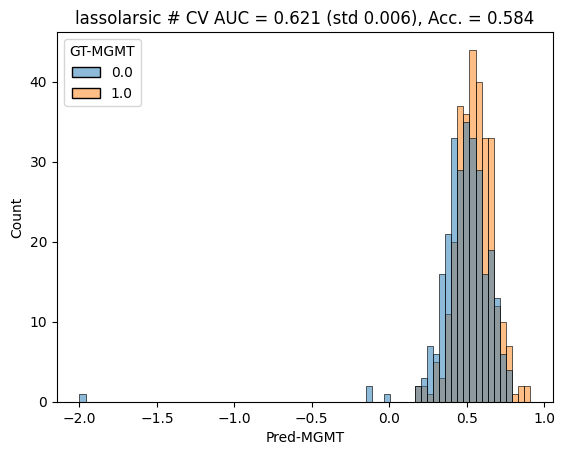

CV AUC = 0.6211059752515768 (std 0.006276175879750908), Acc. = 0.584055459272097, aucs: [0.6231671554252199, 0.630791788856305, 0.6119854721549637, 0.6203030303030302, 0.6260188087774294], accs: [0.5897435897435898, 0.6410256410256411, 0.5739130434782609, 0.5478260869565217, 0.5663716814159292]


0.6148297993718259

In [109]:
selected_features = [
    "sphericity",
    "maximum_2d_diameter_row",
    "elongation",
    "energy_0",
    "entropy_0",
    "minimum_0",
    "10percentile_0",
    "uniformity_0",
    "total_energy_1",
    "entropy_1",
    "mean_1",
    "median_1",
    "mean_abs_dev_1",
    "robust_mean_abs_dev_1",
    "skewness_1",
    "kurtosis_1",
    "uniformity_1",
    "10percentile_2",
    "90percentile_2",
    "maximum_2",
    "mean_abs_dev_2",
    "kurtosis_2",
    "uniformity_2",
    "joint_avg_0",
    "contrast_0",
    "cluster_shade_0",
    "cluster_tendency_0",
    "correlation_0",
    "autocorrelation_1",
    "cluster_prominence_1",
    "difference_variance_1",
    "joint_entropy_1",
    "autocorrelation_2",
    "joint_avg_2",
    "difference_average_2",
    "difference_entropy_2",
    "difference_variance_2",
    "joint_energy_2",
    "joint_entropy_2",
    "mean_ax_1",
    "percentile90_ax_1",
    "mean_ax_2",
    "median_ax_2",
]

feature_pruned_parameters = {
    'model_type': 'lassolarsic',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features,
    'noise_aug' : 0.2,
    'multiply_train_set' : 2,
    'seed' : 3
}
tuned_lassolarsic_parameters = feature_pruned_parameters.copy()
measure_cv_score(tuned_lassolarsic_parameters, verbose=True, plot=True)

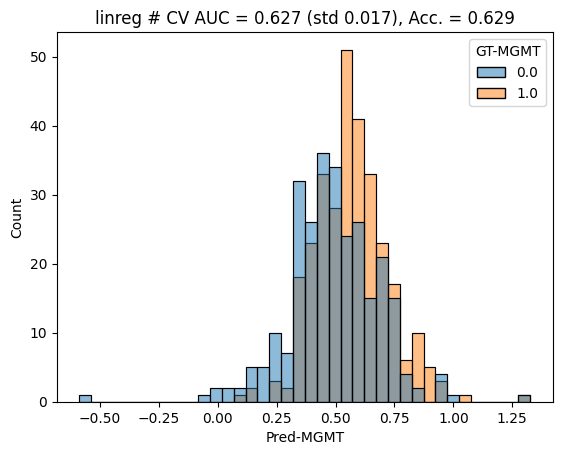

CV AUC = 0.6270764119601329 (std 0.01714274887783513), Acc. = 0.6291161178509532, aucs: [0.6035190615835777, 0.6451612903225807, 0.6122881355932204, 0.6445454545454545, 0.6354231974921629], accs: [0.6153846153846154, 0.6410256410256411, 0.6086956521739131, 0.6608695652173913, 0.6194690265486725]


0.6099336630822977

In [83]:
tuned_linreg_parameters = {
    'model_type': 'linreg',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features,
    'noise_aug' : 0.2,
    'multiply_train_set' : 4,
    'seed' : 3
}
measure_cv_score(tuned_linreg_parameters, verbose=True, plot=True)

In [92]:
def feat_selection_linreg_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = tuned_linreg_parameters.copy()
    parameters['features'] = kept_feats
    
    seeds = list(range(10))
    runs = []
    for seed in seeds:
        parameters['seed'] = seed
        runs.append(measure_cv_score(parameters, verbose=False))
    
    runs = np.array(runs)
    
    return 1 - np.mean(runs) + np.std(runs)

if 0:
    study = optuna.create_study()
    study.optimize(feat_selection_linreg_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

In [93]:
if 0:
    for name, sel in study.best_params.items():
        if sel == 1:
            print(f'"{name}",')

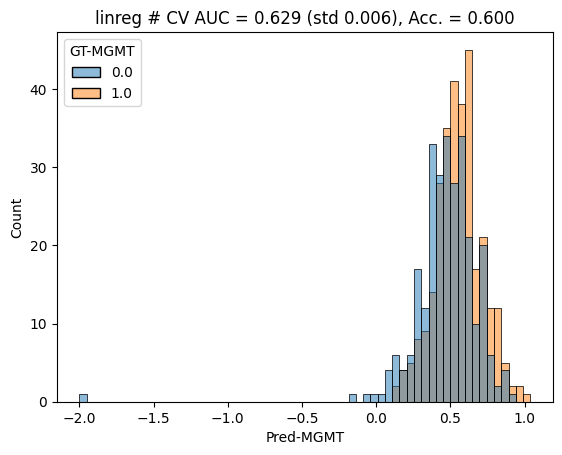

CV AUC = 0.628821801723723 (std 0.006467357199338066), Acc. = 0.5996533795493935, aucs: [0.6202346041055717, 0.6387096774193549, 0.6286319612590798, 0.6251515151515151, 0.6338557993730408], accs: [0.5726495726495726, 0.5897435897435898, 0.591304347826087, 0.6173913043478261, 0.6283185840707964]


0.6223544445243849

In [91]:
selected_linreg_features = [
    "mesh_volume",
    "surface_volume_ratio",
    "spherical_disproportion",
    "maximum_2d_diameter_slice",
    "maximum_2d_diameter_column",
    "major_axis_length",
    "energy_0",
    "total_energy_0",
    "minimum_0",
    "10percentile_0",
    "90percentile_0",
    "mean_0",
    "median_0",
    "robust_mean_abs_dev_0",
    "skewness_0",
    "minimum_1",
    "maximum_1",
    "median_1",
    "mean_abs_dev_1",
    "kurtosis_1",
    "total_energy_2",
    "entropy_2",
    "maximum_2",
    "mean_2",
    "median_2",
    "mean_abs_dev_2",
    "robust_mean_abs_dev_2",
    "kurtosis_2",
    "uniformity_2",
    "joint_avg_0",
    "cluster_shade_0",
    "cluster_tendency_0",
    "correlation_0",
    "joint_avg_1",
    "contrast_1",
    "correlation_1",
    "difference_average_1",
    "difference_variance_1",
    "joint_energy_1",
    "joint_entropy_1",
    "contrast_2",
    "cluster_shade_2",
    "correlation_2",
    "minimum_ax_0",
    "percentile10_ax_1",
    "percentile90_ax_1",
    "maximum_ax_1",
    "minimum_ax_2",
    "percentile90_ax_2",
    "maximum_ax_2",
]

final_linreg_parameters = tuned_linreg_parameters.copy()
final_linreg_parameters['features'] = selected_linreg_features

measure_cv_score(final_linreg_parameters, verbose=True, plot=True)

In [94]:
tuned_ridge_parameters = {
    'model_type': 'ridge',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features,
    'noise_aug' : 0.2,
    'multiply_train_set' : 4,
    'seed' : 3
}
measure_cv_score(tuned_ridge_parameters, verbose=True, plot=False)

CV AUC = 0.6269319659107324 (std 0.016674342115780904), Acc. = 0.6273830155979203, aucs: [0.6041055718475073, 0.6451612903225806, 0.6131961259079903, 0.6442424242424242, 0.6344827586206897], accs: [0.6153846153846154, 0.6324786324786325, 0.6086956521739131, 0.6608695652173913, 0.6194690265486725]


0.6102576237949515

In [99]:
def feat_selection_ridge_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = tuned_ridge_parameters.copy()
    parameters['features'] = kept_feats
    
    seeds = list(range(10))
    runs = []
    for seed in seeds:
        parameters['seed'] = seed
        runs.append(measure_cv_score(parameters, verbose=False))
    
    runs = np.array(runs)
    
    return 1 - np.mean(runs) + np.std(runs)

if 0:
    study = optuna.create_study()
    study.optimize(feat_selection_ridge_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

In [100]:
if 0:
    for name, sel in study.best_params.items():
        if sel == 1:
            print(f'"{name}",')

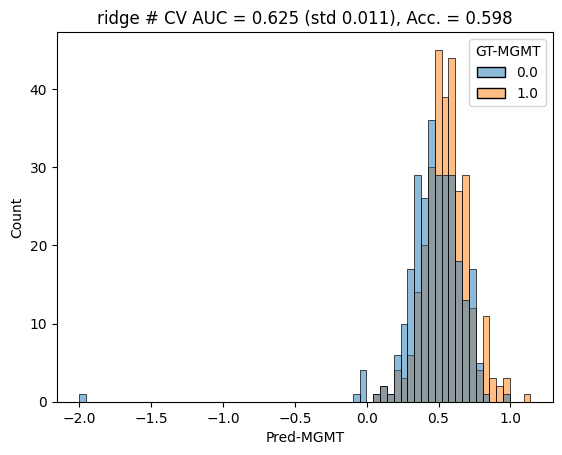

CV AUC = 0.6252106504887092 (std 0.011368071557079666), Acc. = 0.5979202772963604, aucs: [0.6249266862170088, 0.6252199413489736, 0.6101694915254238, 0.6287878787878788, 0.6457680250783701], accs: [0.5726495726495726, 0.6324786324786325, 0.5826086956521739, 0.5652173913043478, 0.6371681415929203]


0.6138425789316295

In [103]:
selected_ridge_features = [
    "surface_volume_ratio",
    "maximum_3d_diameter",
    "maximum_2d_diameter_column",
    "maximum_2d_diameter_row",
    "minor_axis_length",
    "least_axis_length",
    "elongation",
    "total_energy_0",
    "entropy_0",
    "10percentile_0",
    "maximum_0",
    "skewness_0",
    "uniformity_0",
    "energy_1",
    "entropy_1",
    "skewness_1",
    "kurtosis_1",
    "uniformity_1",
    "energy_2",
    "total_energy_2",
    "entropy_2",
    "mean_2",
    "mean_abs_dev_2",
    "robust_mean_abs_dev_2",
    "kurtosis_2",
    "joint_avg_0",
    "contrast_0",
    "cluster_prominence_0",
    "correlation_0",
    "difference_entropy_0",
    "autocorrelation_1",
    "cluster_prominence_1",
    "difference_average_1",
    "difference_entropy_1",
    "difference_variance_1",
    "autocorrelation_2",
    "joint_avg_2",
    "contrast_2",
    "cluster_tendency_2",
    "difference_average_2",
    "difference_variance_2",
    "joint_entropy_2",
    "percentile10_ax_1",
    "median_ax_1",
    "median_ax_2",
    "percentile90_ax_2",
]

final_ridge_parameters = tuned_ridge_parameters.copy()
final_ridge_parameters['features'] = selected_ridge_features

final_ridge_parameters['seed'] = 155

measure_cv_score(final_ridge_parameters, verbose=True, plot=True)

Models that perform well are LassoLarsIC, LinearRegression and RidgeRegression

## Ensemble of three models

In [110]:
def normalize_pred_distribution(preds, min_percentile=10, max_percentile=90):
    """ Clips min and max percentiles and Z-score normalizes """
    min_range = np.percentile(preds, min_percentile)
    max_range = np.percentile(preds, max_percentile)
    norm_preds = np.clip(preds, min_range, max_range)
    pred_std = np.std(norm_preds)
    pred_mean = np.mean(norm_preds)
    norm_preds = (norm_preds - pred_mean) / (pred_std + 1e-6)
    return norm_preds

def rescale_pred_distribution(preds):
    """ Rescales pred distribution to 0-1 range. Doesn't affect AUC """
    return (preds - np.min(preds)) / (np.max(preds) - np.min(preds) + 1e-6)

acc 0.5823223570190641, auc 0.6303565409986037


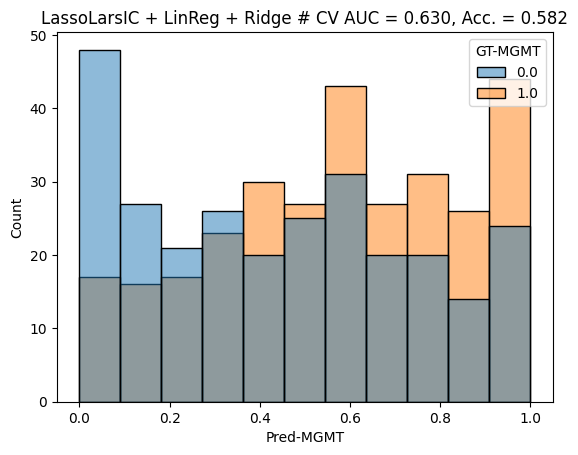

In [111]:
val_preds, val_gts = [], []
for params in [tuned_lassolarsic_parameters, final_linreg_parameters, final_ridge_parameters]:
    val_pred, val_gt, _ = measure_cv_score(params, return_oof_preds=True)
    val_preds.append(normalize_pred_distribution(val_pred))
    val_gts.append(val_gt)
val_preds = rescale_pred_distribution(np.mean(np.stack(val_preds), axis=0))
val_gts = np.mean(np.stack(val_gts), axis=0)

oof_acc = accuracy_score((np.array(val_gts) > 0.5).flatten(), (np.array(val_preds) > 0.5).flatten())
oof_auc = roc_auc_score(np.array(val_gts).flatten().astype(np.float32), np.array(val_preds).flatten())
print(f'acc {oof_acc}, auc {oof_auc}')

plt.close('all')
df_plot = pd.DataFrame({'Pred-MGMT': val_preds, 'GT-MGMT': val_gts})
sns.histplot(x='Pred-MGMT', hue='GT-MGMT', data=df_plot)
plt.title(f'LassoLarsIC + LinReg + Ridge # CV AUC = {oof_auc:.3f}, Acc. = {oof_acc:.3f}')
plt.show()

In [112]:
from joblib import dump, load
import json

save_dir = '../output/2021011_segmentation_feature_model_v4'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for i, params in enumerate([tuned_lassolarsic_parameters, final_linreg_parameters, final_ridge_parameters]):
    model, scaler = measure_cv_score(params, train_one_model=True)
    model_fn = os.path.join(save_dir, f'feature_model_{i}.joblib')
    dump(model, model_fn)
    
    #save oof preds
    oof_preds, oof_gts, oof_index_values = measure_cv_score(params, return_oof_preds=True)
    df_oof = df_all.copy()
    df_oof['oof_pred'] = 0.5
    df_oof = df_oof[['BraTS21ID','MGMT_value','fold','oof_pred']]
    df_oof.loc[np.array(oof_index_values), 'oof_pred'] = oof_preds
    df_oof.to_csv(os.path.join(save_dir, f'feature_model_oofs_{i}.csv'), index=False)

    scaler_fn = os.path.join(save_dir, f'feature_model_scaler_{i}.joblib')
    dump(scaler, scaler_fn)

    param_fn = os.path.join(save_dir, f'params_{i}.json')
    with open(param_fn, 'w', encoding='utf-8') as f:
        json.dump(params, f, indent=4)